In [3]:
!pip install perceval-quandela merlinquantum

In [ ]:
!git clone https://github.com/merlinquantum/merlin.git


In [18]:
import torch, torch.nn as nn
import merlin as ML
import shutil
import json
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, DataLoader
from tqdm import tqdm
import perceval as pcvl
import sys; sys.path.insert(0, '..')
import pandas as pd
#from models.qgan import QGAN
#from helpers.data.digits import DigitsDataset
from torch.utils.data import Dataset
from pathlib import Path
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

In [5]:
import zipfile

# Path to your uploaded zip
zip_path = "/content/optical+recognition+of+handwritten+digits.zip"
extract_dir = "/mnt/data/optdigits_extracted"
csv_out = "/mnt/data/optdigits_csv.csv"

# If CSV not already built, extract and create it
if not os.path.exists(csv_out):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)

    # Look for .tra and .tes inside
    tra_file = [f for f in os.listdir(extract_dir) if f.endswith(".tra")][0]
    tes_file = [f for f in os.listdir(extract_dir) if f.endswith(".tes")][0]

    import pandas as pd
    df_train = pd.read_csv(os.path.join(extract_dir, tra_file), header=None)
    df_test = pd.read_csv(os.path.join(extract_dir, tes_file), header=None)
    df_all = pd.concat([df_train, df_test], ignore_index=True)
    df_all.to_csv(csv_out, index=False, header=False)
    print(f"[Dataset] Built {csv_out} with shape {df_all.shape}")


In [37]:
class MerlinGenerator(nn.Module):
    def __init__(self, latent_dim: int, shots: int = 1000, n_params: int = 40):
        super().__init__()
        # Photonic generator layer
        self.q = ML.QuantumLayer.simple(input_size=latent_dim, n_params=n_params, shots=shots)
        # Map quantum output to 64 pixels (8x8)
        self.map = nn.Linear(self.q.output_size, 64)

    def forward(self, z):
        z01 = torch.sigmoid(z)
        qout = self.q(z01)
        img_flat = self.map(qout)
        return torch.sigmoid(img_flat)


class MerlinDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x: (B, 64) or (B, 1, 8, 8)
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        return self.net(x).view(-1)

In [39]:
class QGAN:
    def __init__(self, image_size, gen_count, gen_arch, input_state, noise_dim, batch_size, pnr, lossy):
        self.image_size = image_size  # expected 8
        self.gen_count = gen_count
        self.noise_dim = max(1, int(noise_dim))
        self.latent_dim = self.noise_dim * max(1, int(gen_count))  # simple aggregation
        self.batch_size = int(batch_size)

        # Models
        self.G = MerlinGenerator(latent_dim=self.latent_dim, shots=1000, n_params=40)
        self.D = MerlinDiscriminator()

        # Opts (set during fit)
        self.optG = None
        self.optD = None

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.G.to(self.device)
        self.D.to(self.device)

        log_every = 25

    def fit(self, dataloader, lrD, opt_params, silent=False):
        # Adversarial losses with BCE
        criterion = nn.BCELoss()
        self.optD = torch.optim.Adam(self.D.parameters(), lr=lrD, betas=(0.5, 0.999))
        self.optG = torch.optim.Adam(self.G.parameters(), lr=lrD, betas=(0.5, 0.999))

        total_steps = int(opt_params.get("opt_iter_num", 200))
        steps_done = 0

        D_loss_progress = []
        G_loss_progress = []
        G_params_progress = []
        fake_data_progress = []

        pbar = dataloader if silent else tqdm(dataloader, total=total_steps, desc="Merlin-QGAN training", leave=False)

        for batch in pbar:
            if isinstance(batch, (list, tuple)):
                real_imgs = batch[0]
            else:
                real_imgs = batch
            # real_imgs shape: (B, 1, 8, 8) or (B, 8, 8)
            if real_imgs.dim() == 3:
                real_imgs = real_imgs.unsqueeze(1)
            real_imgs = real_imgs.to(self.device).float()
            real_flat = real_imgs.view(real_imgs.size(0), -1)

            B = real_imgs.size(0)
            valid = torch.ones(B, device=self.device)
            fake = torch.zeros(B, device=self.device)

            #train the discriminator

            self.optD.zero_grad()
            # Real
            real_pred = self.D(real_flat)
            loss_real = criterion(real_pred, valid)
            # Fake
            z = torch.randn(B, self.latent_dim, device=self.device)
            fake_flat = self.G(z).detach()
            fake_pred = self.D(fake_flat)
            loss_fake = criterion(fake_pred, fake)
            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            self.optD.step()

            #Train Generator

            self.optG.zero_grad()
            z = torch.randn(B, self.latent_dim, device=self.device)
            fake_flat = self.G(z)
            pred = self.D(fake_flat)
            loss_G = criterion(pred, valid)
            loss_G.backward()
            self.optG.step()

            # Logging
            D_loss_progress.append(loss_D.item())
            G_loss_progress.append(loss_G.item())

            # Record generator parameters (flatten Merlin layer params)
            with torch.no_grad():
                g_params = torch.cat([p.view(-1) for p in self.G.parameters() if p.requires_grad]).detach().cpu().numpy()
            G_params_progress.append(g_params)

            # Keep a snapshot of generated samples
            fake_data_progress.append(fake_flat.detach().cpu().numpy())

            steps_done += 1
            if steps_done >= total_steps:
                break

        # Stack outputs into expected numpy structures
        fake_data_progress = np.array(fake_data_progress, dtype=object)  # keep list of batches
        return D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress



In [40]:
# definitions and constants
image_size = 8
batch_size = 4
lossy = False
write_to_disk = True

# optimization params
spsa_iter_num = 10500
opt_iter_num = 200
lrD = 0.002
opt_params = {"spsa_iter_num": spsa_iter_num, "opt_iter_num": opt_iter_num}

# define desired run configurations (kept for parity; not used by Merlin QGAN)
arch_grid_45modes = [
    {"noise_dim": 1, "arch": ["var", "enc[2]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[2]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[1]", "var", "enc[3]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"]},
]

input_grid_4modes = [
    {"input_state": [1, 1, 1, 1], "gen_count": 2, "pnr": True},
    {"input_state": [1, 1, 1, 1], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 1], "gen_count": 4, "pnr": True},
]

arch_grid_5modes = [{"noise_dim": 3, "arch": ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"]}]

input_grid_5modes = [
    {"input_state": [0, 1, 0, 1, 0], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 0, 1], "gen_count": 2, "pnr": True},
]

arch_grid_8modes = [
    {"noise_dim": 1, "arch": ["var", "enc[4]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[4]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[2]", "var", "enc[5]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[2]", "var", "var", "enc[5]", "var", "var"]},
    {"noise_dim": 3, "arch": ["var", "enc[1]", "var", "enc[4]", "var", "enc[6]", "var"]},
    {"noise_dim": 4, "arch": ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"]},
]

input_grid_8modes = [{"input_state": [0, 0, 1, 0, 0, 1, 0, 0], "gen_count": 2, "pnr": False}]

config_grid = []
for inp in input_grid_5modes:
    for arch in (arch_grid_45modes + arch_grid_5modes):
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_4modes:
    for arch in arch_grid_45modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_8modes:
    for arch in arch_grid_8modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)


        config_grid = config_grid[:3]

# number of runs for each config combination
runs = 1

In [41]:
class DigitsDataset(Dataset):

    def __init__(self, csv_file, image_size=8, transform=None):
        df = pd.read_csv(csv_file, header=None)
        x = df.iloc[:, :-1].values.astype("float32") / 16.0
        y = df.iloc[:, -1].values.astype("int64")
        self.x = torch.from_numpy(x).view(-1, 1, image_size, image_size)
        self.y = torch.from_numpy(y)
        self.transform = transform

    def __len__(self): return len(self.x)

    def __getitem__(self, idx):
        img, label = self.x[idx], self.y[idx]
        # no transforms needed; already tensor
        return img, label

In [42]:
csv_path = "/mnt/data/optdigits_csv.csv"
dataset = DigitsDataset(csv_file=csv_path)
sampler = RandomSampler(dataset, replacement=True, num_samples=batch_size * opt_iter_num)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, sampler=sampler)

In [43]:
path = "./ideal_merlin/"
if os.path.isdir(path):
    shutil.rmtree(path)
os.makedirs(path, exist_ok=True)

for config_num, config in enumerate(tqdm(config_grid, desc="config", position=0, leave=False)):
    config_path = os.path.join(path, f"config_{config_num}")
    if os.path.isdir(config_path):
        continue
    os.makedirs(config_path, exist_ok=True)

    with open(os.path.join(config_path, "config.json"), "w") as f:
        f.write(json.dumps(config))

    gen_arch = config["arch"]
    noise_dim = config["noise_dim"]
    input_state = config["input_state"]
    pnr = config["pnr"]
    gen_count = config["gen_count"]

    run_num = 0
    for _ in tqdm(range(1000), desc="run", position=1, leave=False):
        if run_num == runs:
            break
        run_num += 1

        save_path = os.path.join(config_path, f"run_{run_num}")
        os.makedirs(save_path, exist_ok=True)
        try:
            qgan = QGAN(
                image_size,
                gen_count,
                gen_arch,
                input_state,      # kept for signature; Merlin ignores
                noise_dim,
                batch_size,
                pnr,
                lossy,
            )
            D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = qgan.fit(
                tqdm(dataloader, desc="iter", position=2, leave=False),
                lrD,
                opt_params,
                silent=True,
            )

            # Save results (same filenames as original, new parent dir)
            # fake_progress: take per-step batch means (64-dim)
            fake_rows = []
            for step_array in fake_data_progress:
                # step_array: (B, 64)
                arr = np.array(step_array)
                if arr.ndim == 2 and arr.shape[1] == 64:
                    fake_rows.append(arr.mean(axis=0))
                else:
                    fake_rows.append(np.zeros(64, dtype=np.float32))
            fake_rows = np.vstack(fake_rows)
            np.savetxt(os.path.join(save_path, "fake_progress.csv"), fake_rows, delimiter=",")

            np.savetxt(
                os.path.join(save_path, "loss_progress.csv"),
                np.array([D_loss_progress, G_loss_progress]).T,
                delimiter=",",
                header="D_loss, G_loss",
            )

            # Save generator parameter snapshots
            # store as object array to avoid huge files
            G_params_array = np.array(G_params_progress, dtype=object)
            np.save(os.path.join(save_path, "G_params_progress.npy"), G_params_array)

        except Exception as exc:
            print("[Merlin-QGAN] Error:", exc)
            shutil.rmtree(save_path)
            run_num -= 1

if __name__ == "__main__":
    pass

run:   0%|          | 0/1000 [00:00<?, ?it/s]

iter:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/merlin/sampling/autodiff.py:20: UserWarning: Sampling was requested but is disabled because gradients are being computed. Sampling during gradient computation would lead to incorrect gradients.
  warnings.warn(


iter:   2%|▏         | 3/200 [00:00<00:08, 24.28it/s]

iter:   3%|▎         | 6/200 [00:00<00:07, 24.59it/s]

iter:   4%|▍         | 9/200 [00:00<00:07, 24.82it/s]

iter:   6%|▌         | 12/200 [00:00<00:07, 24.61it/s]

iter:   8%|▊         | 15/200 [00:00<00:07, 24.44it/s]

iter:   9%|▉         | 18/200 [00:00<00:07, 24.17it/s]

iter:  10%|█         | 21/200 [00:00<00:07, 24.48it/s]

iter:  12%|█▏        | 24/200 [00:00<00:07, 24.43it/s]

iter:  14%|█▎        | 27/200 [00:01<00:07, 23.38it/s]

iter:  15%|█▌        | 30/200 [00:01<00:07, 23.96it/s]

iter:  16%|█▋        | 33/200 [00:01<00:06, 23.94it/s]

iter:  18%|█▊        | 36/200 [00:01<00:06

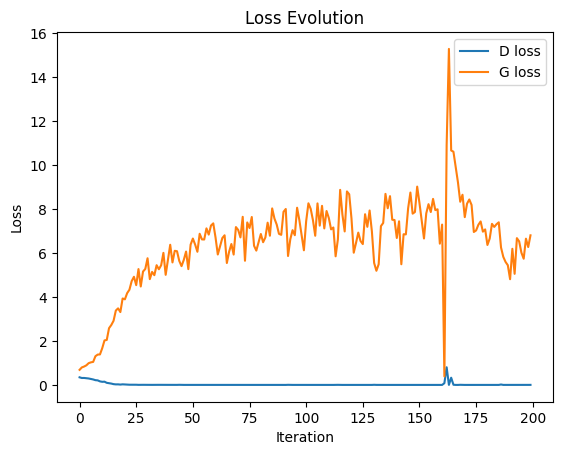

In [46]:


arr = np.loadtxt("/content/ideal_merlin/config_0/run_1/loss_progress.csv", delimiter=",", skiprows=1)
loss_runs = [arr]  # put in a list
fig, ax = plt.subplots()
plot_loss(loss_runs, ax)
plt.show()

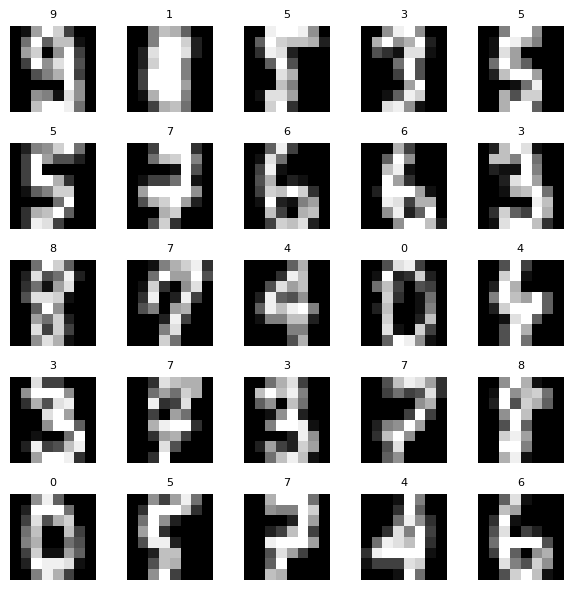

In [47]:
from torch.utils.data import RandomSampler, DataLoader

# Your dataset (using the inline DigitsDataset we defined earlier)
dataset = DigitsDataset(
    csv_file="/mnt/data/optdigits_csv.csv",
    image_size=8,    # 8×8 digits
)

# Sample 25 random items
sampler = RandomSampler(dataset, replacement=True, num_samples=25)
dataloader = DataLoader(dataset, batch_size=1, drop_last=True, sampler=sampler)

# Plot 5×5 grid
plt.figure(figsize=(6, 6))
for index, (image, label) in enumerate(dataloader):
    if index >= 25:
        break
    plt.subplot(5, 5, index + 1)
    img = image[0][0].numpy()   # shape (8,8)
    plt.imshow(img, cmap="gray")
    plt.title(str(label.item()), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

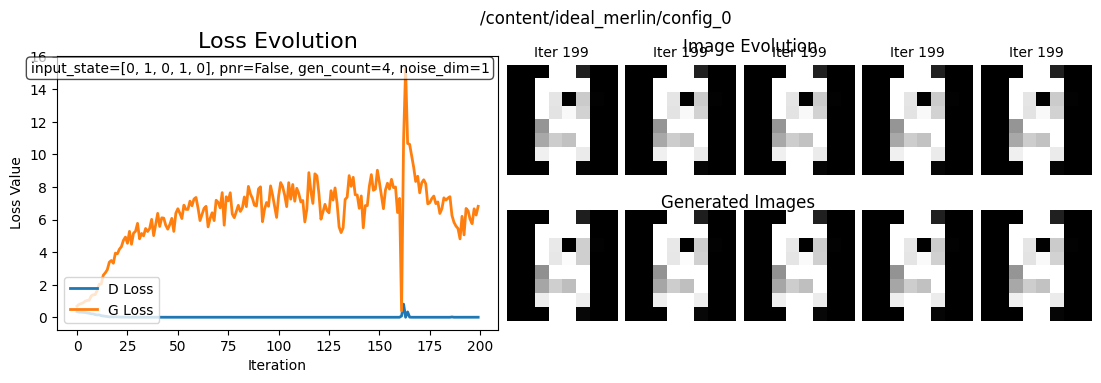

[saved] /content/ideal_merlin/config_0_summary.png


In [48]:
from PIL import Image, ImageEnhance

RESULTS_ROOT = "/content/ideal_merlin"   # change if needed
CONFIG_ID    = "/content/ideal_merlin/config_0"          # e.g. "config_0", "config_1", ...
RUN_LIMIT    = None                # or set e.g. 5 to use only first 5 runs
SHOW_STEPS   = [300, 600, 900, 1200, 1500]  # desired iterations for top row
N_BOTTOM     = 5                   # how many “Generated Images” (final) to show

# ---------- helpers ----------
def load_config_info(cfg_path):
    info = {}
    fjson = os.path.join(cfg_path, "config.json")
    if os.path.isfile(fjson):
        try:
            with open(fjson, "r") as f:
                info = json.load(f)
        except Exception:
            pass
    return info

def safe_loadtxt(path, cols=None, skip_header=True):
    try:
        arr = np.loadtxt(path, delimiter=",", skiprows=1 if skip_header else 0)
        if cols is not None:
            arr = arr[:, cols]
        return arr
    except Exception:
        try:
            arr = np.loadtxt(path, delimiter=",")
            if cols is not None:
                arr = arr[:, cols]
            return arr
        except Exception as e:
            print(f"[warn] could not load {path}: {e}")
            return None

def norm_img(x):
    x = (x - np.min(x)) / (np.ptp(x) + 1e-8)   # <-- use np.ptp
    img = Image.fromarray((x * 255).astype(np.uint8)).convert("L")
    return ImageEnhance.Contrast(img).enhance(1.4)

cfg_path = os.path.join(RESULTS_ROOT, CONFIG_ID)
assert os.path.isdir(cfg_path), f"Config folder not found: {cfg_path}"

runs = sorted(d for d in os.listdir(cfg_path) if d.startswith("run_"))
if RUN_LIMIT is not None:
    runs = runs[:RUN_LIMIT]
assert runs, f"No runs found in {cfg_path}"

loss_runs, fake_runs = [], []
for rn in runs:
    runp = os.path.join(cfg_path, rn)
    lp = os.path.join(runp, "loss_progress.csv")
    fp = os.path.join(runp, "fake_progress.csv")
    larr = safe_loadtxt(lp, cols=[0, 1], skip_header=True)   # D_loss, G_loss
    farr = safe_loadtxt(fp, skip_header=False)               # (T,64)
    if larr is None or farr is None or farr.ndim != 2 or farr.shape[1] != 64:
        print(f"[warn] skipping {runp}")
        continue
    loss_runs.append(larr)
    fake_runs.append(farr)

assert loss_runs and fake_runs, "No valid runs loaded."

# Align to shortest length
T_min = min(arr.shape[0] for arr in loss_runs)
loss_stack = np.stack([arr[:T_min] for arr in loss_runs], axis=0)  # (R,T,2)
fake_stack = np.stack([arr[:T_min] for arr in fake_runs], axis=0)  # (R,T,64)

# Mean/std
D = loss_stack[..., 0] / 2.0   # if your D was averaged like in our training code
G = loss_stack[..., 1]
D_mean, D_std = D.mean(0), D.std(0)
G_mean, G_std = G.mean(0), G.std(0)

# pick evolution indices (clamp to T_min-1)
evo_ids = [min(max(0, s), T_min - 1) for s in SHOW_STEPS]
# bottom images: take the last step of the mean trajectory and create N_BOTTOM variants
traj_mean = fake_stack.mean(0)        # (T,64)
final_img = traj_mean[-1].reshape(8,8)
# For variety on bottom row, sample from last few steps of the first run (or just repeat final)
tail = fake_stack[0, max(0, T_min-N_BOTTOM):T_min]  # (<=N_BOTTOM,64)
if tail.shape[0] < N_BOTTOM:
    tail = np.vstack([tail] + [traj_mean[-1][None,:]] * (N_BOTTOM - tail.shape[0]))

fig = plt.figure(figsize=(12, 3.5), layout="constrained")
gs = fig.add_gridspec(2, 10)

# Left: Loss Evolution
axL = fig.add_subplot(gs[:, :4])
x = np.arange(T_min)
axL.plot(x, D_mean, label="D Loss", linewidth=2)
axL.fill_between(x, D_mean - D_std, D_mean + D_std, alpha=0.2)
axL.plot(x, G_mean, label="G Loss", linewidth=2)
axL.fill_between(x, G_mean - G_std, G_mean + G_std, alpha=0.2)
axL.set_title("Loss Evolution", fontsize=16)
axL.set_xlabel("Iteration")
axL.set_ylabel("Loss Value")
axL.legend(loc="lower left")

# a small config badge
cfg_info = load_config_info(cfg_path)
badge = []
for k in ("input_state", "pnr", "gen_count", "noise_dim"):
    if k in cfg_info:
        badge.append(f"{k}={cfg_info[k]}")
if badge:
    axL.text(0.98, 0.98, ", ".join(badge), transform=axL.transAxes,
             va="top", ha="right",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.7), fontsize=10)

# Right top: Image Evolution
for j, i in enumerate(evo_ids):
    ax = fig.add_subplot(gs[0, 4 + j % 5])
    img = traj_mean[i].reshape(8,8)
    ax.imshow(norm_img(img), cmap="gray")
    ax.set_title(f"Iter {i}", fontsize=10)
    ax.axis("off")
# label for the row
fig.text(0.62, 0.97, "Image Evolution", ha="center", va="top", fontsize=12)

# Right bottom: Generated Images (final-ish)
for j in range(N_BOTTOM):
    ax = fig.add_subplot(gs[1, 4 + j % 5])
    img = tail[j].reshape(8,8)
    ax.imshow(norm_img(img), cmap="gray")
    ax.axis("off")
fig.text(0.61, 0.50, "Generated Images", ha="center", va="center", fontsize=12)

plt.suptitle(f"{CONFIG_ID}", y=1.05, fontsize=12)

# Save next to results for convenience
out_png = os.path.join(RESULTS_ROOT, f"{CONFIG_ID}_summary.png")
plt.savefig(out_png, dpi=160, bbox_inches="tight")
plt.show()
print(f"[saved] {out_png}")